# 1. Carga de las librerías

In [1]:
import os
import json
import pickle
import joblib
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
import xgboost as xgb
from xgboost import XGBRegressor

# Validación y búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import optuna
from optuna.integration import TFKerasPruningCallback

# Métricas de evaluación
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
)

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Ignorar advertencias
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')


2024-12-29 11:54:18.310891: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Definición de periodos de entrenamiento y validación

Se divide el conjunto de datos por rango de fechas en lugar de aleatoriamente para evitar el "data leakage" y que el modelo utilice datos futuros para predecir datos pasados.

In [2]:
# Se cargan los datos
file_path = "PdM_processed.csv"  # Ruta del archivo
data = pd.read_csv(file_path)

data['datetime'] = pd.to_datetime(data['datetime'])


# Se asegura de que los datos estén ordenados cronológicamente
data = data.sort_values(by='datetime')


# Se definen los puntos de corte temporal para dividir el dataset
split_date = '2015-07-01 00:00:00'  # Primera fecha de corte
split_date_val = '2015-10-01 00:00:00'  # Segunda fecha de corte

# Conjunto de entrenamiento (antes del primer corte)
train_data = data[data['datetime'] < split_date]

# Conjunto de validación (entre las dos fechas de corte)
val_data = data[(data['datetime'] >= split_date) & (data['datetime'] < split_date_val)]

# Conjunto de prueba (después del segundo corte)
test_data = data[data['datetime'] >= split_date_val]

# Se muestra el tamaño de cada conjunto
print(f"Total de registros: {data.shape[0]}")
print(f"Total de registros en entrenamiento: {train_data.shape[0]}")
print(f"Total de registros en validación: {val_data.shape[0]}")
print(f"Total de registros en prueba: {test_data.shape[0]}")

# Se separan las características y etiquetas para cada conjunto
feature_columns = [col for col in data.columns if col not in ['datetime','failure', 'RUL', 'near_failure']]

# Entrenamiento
X_train = train_data[feature_columns]
y_train_failure = train_data['failure']  # Multiclase
y_train_RUL = train_data['RUL']
y_train_near_failure = train_data['near_failure']

# Validación
X_val = val_data[feature_columns]
y_val_failure = val_data['failure']
y_val_RUL = val_data['RUL']
y_val_near_failure = val_data['near_failure']

# Prueba
X_test = test_data[feature_columns]
y_test_failure = test_data['failure']
y_test_RUL = test_data['RUL']
y_test_near_failure = test_data['near_failure']

Total de registros: 877032
Total de registros en entrenamiento: 434253
Total de registros en validación: 221049
Total de registros en prueba: 221730


# 3. Optimización de hiperparámetros

## 3.1 Reducir el tamaño del conjunto de datos (Subsampling)


Dado el gran volumen de datos, se selecciona una muestra del 30% para determinar los mejores hiperparámetros.


In [3]:
sample_frac = 0.3  # Porcentaje de los datos utilizado
num_samples = int(len(X_train) * sample_frac)  # Número de filas a seleccionar

# Seleccionar las primeras filas (respetando el orden temporal)
X_train_sample = X_train.iloc[:num_samples]
y_train_sample_RUL = y_train_RUL.iloc[:num_samples]
y_train_sample_failure = y_train_failure.iloc[:num_samples]
y_train_sample_near_failure = y_train_near_failure.iloc[:num_samples]

In [4]:
# Se muestra el tamaño de cada conjunto
print(f"Total de registros en X_train_sample: {X_train_sample.shape[0]}")
print(f"Total de registros en y_train_sample_RUL: {len(y_train_sample_RUL)}")
print(f"Total de registros en y_train_sample_failure: {len(y_train_sample_failure)}")
print(f"Total de registros en y_train_sample_near_failure: {len(y_train_sample_near_failure)}")

Total de registros en X_train_sample: 130275
Total de registros en y_train_sample_RUL: 130275
Total de registros en y_train_sample_failure: 130275
Total de registros en y_train_sample_near_failure: 130275


## 3.2 Búsqueda de hiperparámetros

In [5]:
# Directorio para guardar los resultados
base_dir = "hyperparams"
os.makedirs(base_dir, exist_ok=True)  # Crear el directorio si no existe

def save_hyperparams(task_name, params):
    """
    Guarda los mejores hiperparámetros en un archivo JSON separado por tarea.
    """
    file_path = os.path.join(base_dir, f"{task_name}_best_params.json")
    with open(file_path, 'w') as f:
        json.dump(params, f)

def load_hyperparams(task_name):
    """
    Carga los mejores hiperparámetros desde un archivo JSON, si existe.
    """
    file_path = os.path.join(base_dir, f"{task_name}_best_params.json")
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return json.load(f)
    return None

In [6]:
# Definición de los hiperparámetros para todos los modelos

# ================== MODELOS DE REGRESIÓN ==================

rf_reg_params = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_reg_params = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [3, 6, 9, 12, 15],
    'learning_rate': [0.001, 0.01, 0.1]
}

# ================== MODELOS DE CLASIFICACIÓN ==================

lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

dt_params = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf_params = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}


### MODELOS DE REGRESIÓN (RUL)

In [7]:
print("Iniciando búsqueda de hiperparámetros.")

# ================== MODELOS DE REGRESIÓN (RUL) ==================
print("\n1. Optimización de modelos para RUL")

# Random Forest Regressor para RUL
task_name = "rul_rf"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando Random Forest Regressor para RUL")

    rf_reg = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid=rf_reg_params,
        scoring = {
            'rmse': 'neg_root_mean_squared_error',
            'mae': 'neg_mean_absolute_error',
            'r2': 'r2'
    },
        refit='rmse',
        cv = TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    rf_reg.fit(X_train_sample, y_train_sample_RUL)
    best_params = rf_reg.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros RF Regressor:", best_params)


Iniciando búsqueda de hiperparámetros.

1. Optimización de modelos para RUL
Mejores hiperparámetros obtenidos para rul_rf: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [8]:
# XGBoost Regressor para RUL
task_name = "rul_xgb"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando XGBoost Regressor para RUL.")

    xgb_reg = GridSearchCV(
        XGBRegressor(random_state=42),
        param_grid=xgb_reg_params,
        scoring = {
            'rmse': 'neg_root_mean_squared_error',
            'mae': 'neg_mean_absolute_error',
            'r2': 'r2'
    },
        refit='rmse',
        cv = TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    xgb_reg.fit(X_train_sample, y_train_sample_RUL)
    best_params = xgb_reg.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros XGBoost Regressor:", best_params)

Mejores hiperparámetros obtenidos para rul_xgb: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


### MODELOS DE CLASIFICACIÓN (FAILURE)

In [9]:
# ================== MODELOS DE CLASIFICACIÓN (FAILURE) ==================
print("\n2. Optimización de modelos para Failure")

# Logistic Regression para Failure
task_name = "failure_lr"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando Logistic Regression para Failure.")

    lr = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced', tol=1e-5),
        param_grid=lr_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    lr.fit(X_train_sample, y_train_sample_failure)
    best_params = lr.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros Logistic Regression:", best_params)


2. Optimización de modelos para Failure
Mejores hiperparámetros obtenidos para failure_lr: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [10]:
# Decision Tree para Failure
task_name = "failure_dt"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando Decision Tree para Failure.")

    dt = GridSearchCV(
        DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        param_grid=dt_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    dt.fit(X_train_sample, y_train_sample_failure)
    best_params = dt.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros Decision Tree:", best_params)


Mejores hiperparámetros obtenidos para failure_dt: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [11]:
# Random Forest Classifier para Failure
task_name = "failure_rf"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando Random Forest Classifier para Failure.")
    
    rf_clf = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        param_grid=rf_clf_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    rf_clf.fit(X_train_sample, y_train_sample_failure)
    best_params = rf_clf.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros Random Forest Classifier:", best_params)
    
    

Mejores hiperparámetros obtenidos para failure_rf: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}


In [12]:
# SVM para Failure
task_name = "failure_svm"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando SVM para Failure.")

    svm = GridSearchCV(
        SVC(random_state=42, probability=True, class_weight='balanced'),
        param_grid=svm_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    svm.fit(X_train_sample, y_train_sample_failure)
    best_params = svm.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros SVM:", best_params)

Mejores hiperparámetros obtenidos para failure_svm: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


### MODELOS DE CLASIFICACIÓN (NEAR_FAILURE)

In [13]:
# ================== MODELOS DE CLASIFICACIÓN (NEAR_FAILURE) ==================
print("\n3. Optimización de modelos para Near Failure")

# Logistic Regression para Near Failure
task_name = "near_failure_lr"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando Logistic Regression para Near Failure.")
    lr_near = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced'),
        param_grid=lr_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    lr_near.fit(X_train_sample, y_train_sample_near_failure)
    best_params = lr_near.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros Logistic Regression Near Failure:", best_params)


3. Optimización de modelos para Near Failure
Mejores hiperparámetros obtenidos para near_failure_lr: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [14]:
# Decision Tree para Near Failure
task_name = "near_failure_dt"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando Decision Tree para Near Failure.")
    dt_near = GridSearchCV(
        DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        param_grid=dt_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    dt_near.fit(X_train_sample, y_train_sample_near_failure)
    best_params = dt_near.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros Decision Tree Near Failure:", best_params)



Mejores hiperparámetros obtenidos para near_failure_dt: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [15]:
# Random Forest Classifier para Near Failure
task_name = "near_failure_rf"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando Random Forest para Near Failure.")
    rf_near = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        param_grid=rf_clf_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1
    )

    rf_near.fit(X_train_sample, y_train_sample_near_failure)
    best_params = rf_near.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros Random Forest Near Failure:", best_params)


Mejores hiperparámetros obtenidos para near_failure_rf: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [16]:
# SVM para Near Failure
task_name = "near_failure_svm"
best_params = load_hyperparams(task_name)

if best_params:
    print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
else:
    print("\nOptimizando SVM para Near Failure.")
    svm_near = GridSearchCV(
        SVC(random_state=42, probability=True, class_weight='balanced'),
        param_grid=svm_params,
        scoring={
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'accuracy': 'accuracy'
        },
        refit='f1',
        cv=TimeSeriesSplit(n_splits=3),
        n_jobs=-1,
        verbose=3
    )

    svm_near.fit(X_train_sample, y_train_sample_near_failure)
    best_params = svm_near.best_params_
    save_hyperparams(task_name, best_params)
    print("Mejores hiperparámetros SVM Near Failure:", best_params)
    

Mejores hiperparámetros obtenidos para near_failure_svm: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}


### Redes neuronales con Keras

Se implementan modelos de redes neuronales con Keras para clasificación binaria (Near Failure), clasificación multiclase (Failure) y regresión (RUL) y se optimizan sus hiperparámetros usando Optuna.

In [17]:
def optimize_model(trial, model_type, X_train, y_train, X_val, y_val, output_shape=1):
    """
    Optimiza un modelo con Keras utilizando Optuna.

    Parámetros:
    - trial: Instancia de Optuna para sugerir hiperparámetros.
    - model_type: Tipo de modelo ('binary', 'multiclass', 'regression').
    - X_train, y_train, X_val, y_val: Conjuntos de datos.
    - output_shape: Número de salidas (1 para binaria/regresión, n_clases para multiclase).

    Retorna:
    - Métrica objetivo (F1 o MSE dependiendo del tipo).
    """
    # Hiperparámetros sugeridos 
    num_units = trial.suggest_int('num_units', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    num_epochs = trial.suggest_int('num_epochs', 10, 20)

    # Construcción del modelo
    model = Sequential([
        Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(output_shape, activation=('sigmoid' if model_type == 'binary' else
                                        'softmax' if model_type == 'multiclass' else None))
    ])

    # Compilación del modelo
    if model_type == 'binary':
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy', metrics=['accuracy'])
    elif model_type == 'multiclass':
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss=SparseCategoricalCrossentropy(from_logits=False),  # Cambio aquí
                      metrics=['accuracy'])
    elif model_type == 'regression':
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='mse', metrics=['mae'])
    else:
        raise ValueError("Tipo de modelo no soportado. Usa 'binary', 'multiclass' o 'regression'.")

    # Entrenamiento
    callbacks = [TFKerasPruningCallback(trial, 'val_loss')]
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=num_epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks
    )

    # Evaluación del modelo
    if model_type == 'binary':
        y_pred = (model.predict(X_val) > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred, average='weighted')
        return f1  # Maximizar F1

    elif model_type == 'multiclass':
        y_pred = model.predict(X_val).argmax(axis=1)  
        f1 = f1_score(y_val, y_pred, average='weighted')  
        return f1  # Maximizar F1

    elif model_type == 'regression':
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        return mse  # Minimizar MSE


def optimize_with_optuna(task_name, model_type, direction, X_train, y_train, X_val, y_val, output_shape=1, n_trials=50):
    """
    Optimiza hiperparámetros usando Optuna y guarda los mejores en un archivo JSON.

    Parámetros:
    - task_name: Nombre de la tarea (para guardar los hiperparámetros).
    - model_type: Tipo de modelo ('binary', 'multiclass', 'regression').
    - direction: 'maximize' o 'minimize'.
    - X_train, y_train, X_val, y_val: Conjuntos de datos.
    - output_shape: Número de salidas (1 para binaria/regresión, n_clases para multiclase).
    - n_trials: Número de pruebas en Optuna.

    Retorna:
    - Los mejores hiperparámetros obtenidos.
    """
    # Se cargan los hiperparámetros si ya existe un json con ellos
    best_params = load_hyperparams(task_name)
    if best_params:
        print(f"Mejores hiperparámetros obtenidos para {task_name}: {best_params}")
        return best_params

    # Se ejecuta Optuna si no hay archivo de resultados guardado
    print(f"Ejecutando optimización para {task_name}.")

    def objective(trial):
        return optimize_model(trial, model_type, X_train, y_train, X_val, y_val, output_shape)

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    # Se guardan los mejores hiperparámetros obtenidos
    best_params = study.best_params
    save_hyperparams(task_name, best_params)  
    print(f"Mejores hiperparámetros para {task_name}: {best_params}")
    return best_params

In [18]:
# Regresión (RUL)

task_name = "rul_nn"
best_params_rul = optimize_with_optuna(
    task_name=task_name,
    model_type='regression',
    direction='minimize',
    X_train=X_train_sample,
    y_train=y_train_sample_RUL,
    X_val=X_val,
    y_val=y_val_RUL
)

Mejores hiperparámetros obtenidos para rul_nn: {'num_units': 125, 'dropout_rate': 0.3100915439321596, 'learning_rate': 0.006401151287776159, 'batch_size': 33, 'num_epochs': 15}


In [19]:
# Clasificación multiclase (Failure)

task_name = "failure_nn"
output_shape = len(np.unique(y_train_failure))  # Número de clases

best_params_failure = optimize_with_optuna(
    task_name=task_name,
    model_type='multiclass',
    direction='maximize',
    X_train=X_train_sample,
    y_train=y_train_sample_failure,  
    X_val=X_val,
    y_val=y_val_failure,      
    output_shape=output_shape  
)

Mejores hiperparámetros obtenidos para failure_nn: {'num_units': 60, 'dropout_rate': 0.40826666966239455, 'learning_rate': 0.0007221277702818949, 'batch_size': 50, 'num_epochs': 17}


In [20]:
# Clasificación binaria (Near Failure)

task_name = "near_failure_nn"
best_params_near_failure = optimize_with_optuna(
    task_name=task_name,
    model_type='binary',
    direction='maximize',
    X_train=X_train_sample,
    y_train=y_train_sample_near_failure,
    X_val=X_val,
    y_val=y_val_near_failure
)

Mejores hiperparámetros obtenidos para near_failure_nn: {'num_units': 111, 'dropout_rate': 0.13897992062814235, 'learning_rate': 0.0031001945371067867, 'batch_size': 39, 'num_epochs': 17}


# 4. Entrenamiento de los modelos y resultados

## 4.1 Funciones auxiliares

In [21]:
# Funciones para calcular métricas
def calcular_metricas_regresion(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

def calcular_metricas_clasificacion(y_true, y_pred, y_prob=None):
    report = classification_report(y_true, y_pred, output_dict=True)
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),  # Añade la métrica de Accuracy
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-Score": report['weighted avg']['f1-score']
    }
    if y_prob is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    return metrics

In [22]:
def mostrar_matriz_confusion(y_true, y_pred, modelo):
    """
    Genera y visualiza una matriz de confusión para un modelo dado.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"Matriz de confusión - {modelo}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.savefig(f"img/confusion_matrix_{modelo.lower().replace(' ', '_')}.png")
    plt.show()


In [23]:
def comparar_curvas_roc_multiclase(y_test, y_prob, nombre_modelo):
    """
    Genera una gráfica con las curvas ROC para todas las clases de un modelo multiclase.
    
    Parámetros:
    y_test: array con las etiquetas verdaderas
    y_prob: array con las probabilidades predichas para todas las clases
    nombre_modelo: nombre del modelo para el título
    """
    plt.figure(figsize=(10, 8))
    
    # Se obtienen las clases únicas
    clases = np.unique(y_test)
    
    # Para cada clase
    for i, clase in enumerate(clases):
        # Se convierte el problema a binario (uno contra todos)
        y_test_bin = (y_test == clase).astype(int)
        
        # Se calcula la curva ROC
        fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, i])
        roc_auc = roc_auc_score(y_test_bin, y_prob[:, i])
        
        # Se grafica la curva ROC para esta clase
        plt.plot(fpr, tpr, lw=2, label=f'Clase {clase} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f"Curvas ROC por clase - {nombre_modelo}")
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.legend(loc="lower right")
    plt.savefig(f"img/roc_curve_{nombre_modelo.lower().replace(' ', '_')}.png")
    plt.show()

In [24]:
def comparar_curvas_roc_binario(y_test, modelos_dict):
    """
    Genera una gráfica con las curvas ROC para los diferentes modelos binarios.
    
    Parámetros:
    y_test: array con las etiquetas verdaderas
    modelos_dict: diccionario con las probabilidades predichas por cada modelo
                 formato: {'nombre_modelo': y_prob_test}
    """
    plt.figure(figsize=(10, 8))
    
    for nombre_modelo, y_prob in modelos_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, lw=2, label=f'{nombre_modelo} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title("Curvas ROC por modelo - Near Failure")
    plt.xlabel("Tasa de falsos positivos")
    plt.ylabel("Tasa de verdaderos positivos")
    plt.legend(loc="lower right")
    plt.savefig("img/ roc_curve_near_failure.png")
    plt.show()


## 4.2 Entrenar modelos para RUL (Regresión)

In [25]:
# Comprueba si el directorio existe y, en caso contrario, lo crea

if not os.path.exists("models"):
    os.makedirs("models")

if not os.path.exists("img"):
    os.makedirs("img")


In [26]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/rul_lr_model.pkl"): 
    print("Cargando modelo de Regresión Lineal")
    lr_model = joblib.load("models/rul_lr_model.pkl")
else:
    print("Entrenando modelo de Regresión Lineal")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train_RUL) 
    joblib.dump(lr_model, "models/rul_lr_model.pkl")


# Predicciones
y_pred_val_lr = lr_model.predict(X_val)
y_pred_test_lr = lr_model.predict(X_test)

# Métricas
resultados_lr = {
    "Modelo": "Regresión Lineal",
    "Validación": calcular_metricas_regresion(y_val_RUL, y_pred_val_lr),
    "Prueba": calcular_metricas_regresion(y_test_RUL, y_pred_test_lr)
}

print("Resultados Regresión Lineal:", resultados_lr)


Cargando modelo de Regresión Lineal
Resultados Regresión Lineal: {'Modelo': 'Regresión Lineal', 'Validación': {'MSE': 5736828.567551748, 'RMSE': 2395.167753530376, 'MAE': 1268.8644042551716, 'R2': 0.05621039405329431}, 'Prueba': {'MSE': 31470795.84055247, 'RMSE': 5609.883763550941, 'MAE': 4025.214372671237, 'R2': -0.4386632810407711}}


In [27]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/rul_rf_model.pkl"):
    print("Cargando modelo Random Forest")
    rf_model = joblib.load("models/rul_rf_model.pkl")
else:
    print("Entrenando modelo Random Forest")
    with open('hyperparams/rul_rf_best_params.json', 'r') as f:
        rf_params = json.load(f)
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train_RUL)
    joblib.dump(rf_model, "models/rul_rf_model.pkl")


# Predicciones
y_pred_val_rf = rf_model.predict(X_val)
y_pred_test_rf = rf_model.predict(X_test)

# Métricas
resultados_rf = {
    "Modelo": "Random Forest",
    "Validación": calcular_metricas_regresion(y_val_RUL, y_pred_val_rf),
    "Prueba": calcular_metricas_regresion(y_test_RUL, y_pred_test_rf)
}

print("Resultados Random Forest:", resultados_rf)


Cargando modelo Random Forest
Resultados Random Forest: {'Modelo': 'Random Forest', 'Validación': {'MSE': 4065292.338912383, 'RMSE': 2016.2570121173499, 'MAE': 980.6006485414707, 'R2': 0.3312017939142172}, 'Prueba': {'MSE': 31734487.78370064, 'RMSE': 5633.337180011564, 'MAE': 3881.308836943374, 'R2': -0.45071775586357576}}


In [28]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/rul_xgb_model.pkl"):
    print("Cargando modelo XGBoost")
    xgb_model = joblib.load("models/rul_xgb_model.pkl")
else:
    print("Entrenando modelo XGBoost")
    with open('hyperparams/rul_xgb_best_params.json', 'r') as f:
        xgb_params = json.load(f)
    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train_RUL)
    joblib.dump(xgb_model, "models/rul_xgb_model.pkl")


# Predicciones
y_pred_val_xgb = xgb_model.predict(X_val)
y_pred_test_xgb = xgb_model.predict(X_test)

# Métricas
resultados_xgb = {
    "Modelo": "XGBoost",
    "Validación": calcular_metricas_regresion(y_val_RUL, y_pred_val_xgb),
    "Prueba": calcular_metricas_regresion(y_test_RUL, y_pred_test_xgb)
}

print("Resultados XGBoost:", resultados_xgb)


Cargando modelo XGBoost
Resultados XGBoost: {'Modelo': 'XGBoost', 'Validación': {'MSE': 3988938.5072796955, 'RMSE': 1997.2327123496889, 'MAE': 969.6360615471034, 'R2': 0.3437630813608611}, 'Prueba': {'MSE': 31637861.54781003, 'RMSE': 5624.754354441626, 'MAE': 3879.4670020113003, 'R2': -0.44630056164118237}}


In [29]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/rul_nn_model.keras"):
    print("Cargando modelo Redes Neuronales para RUL Prediction")
    nn_model = load_model("models/rul_nn_model.keras")
else:
    print("Entrenando modelo Redes Neuronales para RUL Prediction")
    with open('hyperparams/rul_nn_best_params.json', 'r') as f:
        nn_params = json.load(f)
    
    # Se crea el modelo
    nn_model = Sequential()
    nn_model.add(Dense(nn_params['num_units'], activation='relu', input_dim=X_train.shape[1]))
    nn_model.add(Dropout(nn_params['dropout_rate']))
    nn_model.add(Dense(1))  
    optimizer = Adam(learning_rate=nn_params['learning_rate'])
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Se entrena el modelo
    nn_model.fit(
        X_train, y_train_RUL,
        validation_data=(X_val, y_val_RUL),
        batch_size=nn_params['batch_size'],
        epochs=nn_params['num_epochs'],
        verbose=1
    )
    nn_model.save("models/rul_nn_model.keras")

# Predicciones
y_pred_test_nn = nn_model.predict(X_test).flatten()

# Métricas
resultados_nn = {
    "Modelo": "Redes Neuronales (Keras)",
    "Prueba": calcular_metricas_regresion(y_test_RUL, y_pred_test_nn)
}

print("Resultados Redes Neuronales (Keras - RUL Prediction):", resultados_nn)


Cargando modelo Redes Neuronales para RUL Prediction
6930/6930 ━━━━━━━━━━━━━━━━━━━━ 6s 840us/step
Resultados Redes Neuronales (Keras - RUL Prediction): {'Modelo': 'Redes Neuronales (Keras)', 'Prueba': {'MSE': 30383536.917711623, 'RMSE': 5512.126351754976, 'MAE': 3946.7953598945383, 'R2': -0.3889600737497918}}


In [30]:
# Resultados
resultados_totales_rul = pd.DataFrame([
    {"Modelo": "Regresión Lineal", **resultados_lr["Prueba"]},
    {"Modelo": "Random Forest", **resultados_rf["Prueba"]},
    {"Modelo": "XGBoost", **resultados_xgb["Prueba"]},
    {"Modelo": "Redes Neuronales (Keras)", **resultados_nn["Prueba"]}
])

# Se muestran los resultados
print("Resultados para RUL:")
print(resultados_totales_rul)


Resultados para RUL:
                     Modelo           MSE         RMSE          MAE        R2
0          Regresión Lineal  3.147080e+07  5609.883764  4025.214373 -0.438663
1             Random Forest  3.173449e+07  5633.337180  3881.308837 -0.450718
2                   XGBoost  3.163786e+07  5624.754354  3879.467002 -0.446301
3  Redes Neuronales (Keras)  3.038354e+07  5512.126352  3946.795360 -0.388960


## 4.3 Entrenar modelos para Failure (Clasificación multiclase)

Cargando modelo de Regresión Logística para Failure Prediction
Resultados Regresión Logística (Failure Prediction):
 {'Accuracy': 0.9991205520227303, 'Precision': 0.9989781673924546, 'Recall': 0.9991205520227303, 'F1-Score': 0.9990208259596697, 'ROC-AUC': 0.9806173932512959}


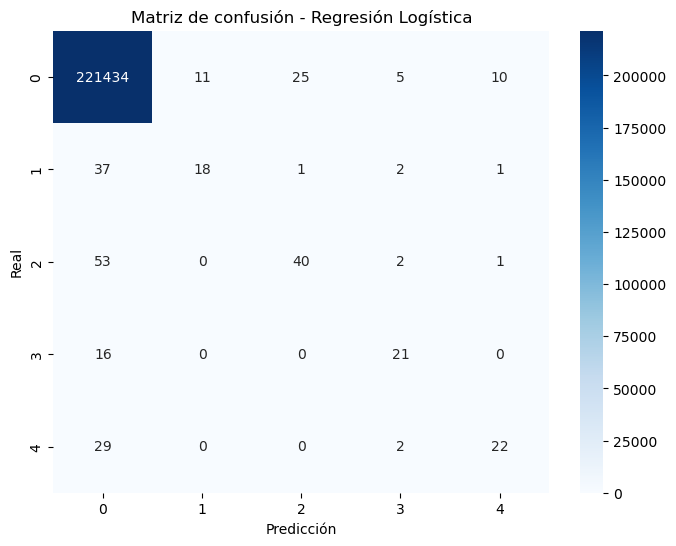

In [31]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/failure_lr_model.pkl"):
    print("Cargando modelo de Regresión Logística para Failure Prediction")
    lr_model = joblib.load("models/failure_lr_model.pkl")
else:
    print("Entrenando modelo de Regresión Logística para Failure Prediction")
    with open('hyperparams/failure_lr_best_params.json', 'r') as f:
        lr_params = json.load(f)
    lr_model = LogisticRegression(**lr_params)
    lr_model.fit(X_train, y_train_failure)
    joblib.dump(lr_model, "models/failure_lr_model.pkl")

# Predicciones
y_pred_test_lr = lr_model.predict(X_test)
y_prob_test_lr = lr_model.predict_proba(X_test)  

# Métricas
resultados_lr = calcular_metricas_clasificacion(y_test_failure, y_pred_test_lr, y_prob_test_lr)
print("Resultados Regresión Logística (Failure Prediction):\n", resultados_lr)

# Matriz de confusión
mostrar_matriz_confusion(y_test_failure, y_pred_test_lr, "Regresión Logística")
    

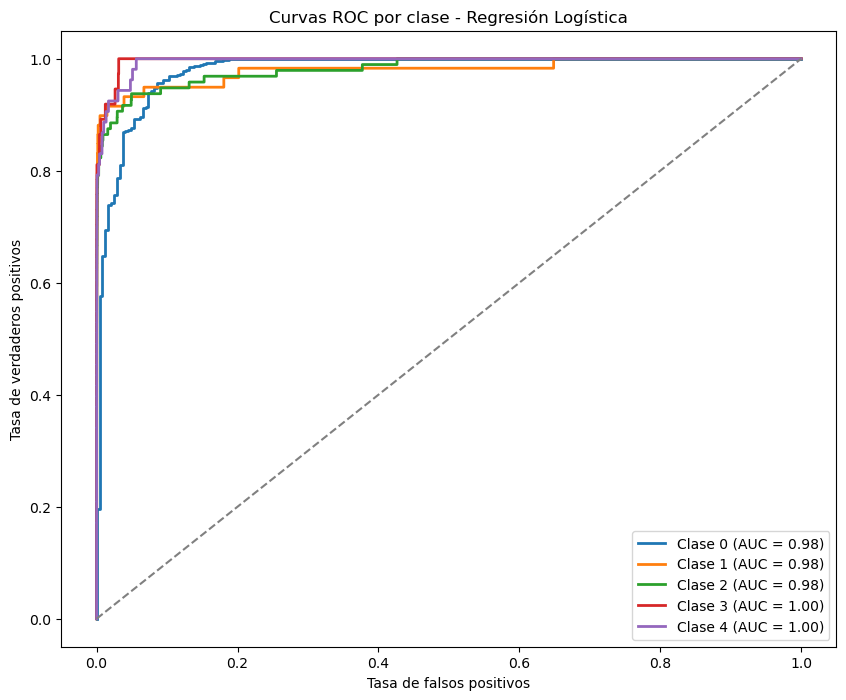

In [32]:
# Se genera una curva ROC que permita comparar todas las clases de un modelo

comparar_curvas_roc_multiclase(
    y_test_failure,
    y_prob_test_lr,
    "Regresión Logística"
)


Cargando modelo de Árbol de Decisión para Failure Prediction
Resultados Árbol de Decisión (Failure Prediction):
 {'Accuracy': 0.9985477833400983, 'Precision': 0.9986760406942957, 'Recall': 0.9985477833400983, 'F1-Score': 0.9986083189091236, 'ROC-AUC': 0.7464989146905139}


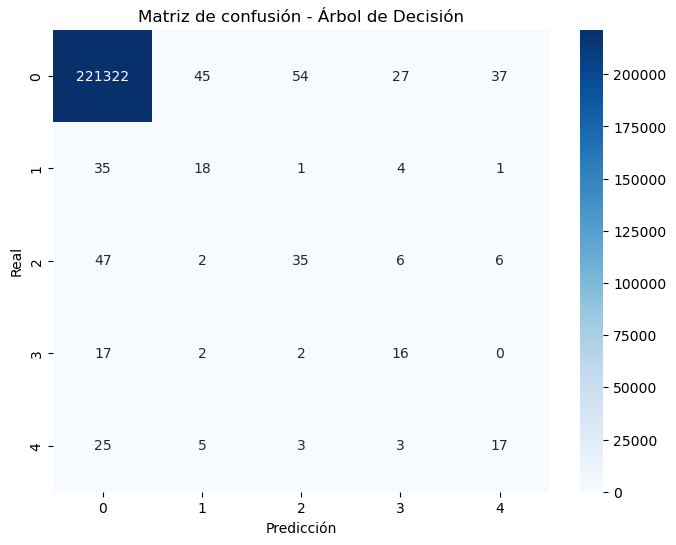

In [33]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/failure_dt_model.pkl"):
    print("Cargando modelo de Árbol de Decisión para Failure Prediction")
    dt_model = joblib.load("models/failure_dt_model.pkl")
else:
    print("Entrenando modelo de Árbol de Decisión para Failure Prediction")
    with open('hyperparams/failure_dt_best_params.json', 'r') as f:
        dt_params = json.load(f)
    dt_model = DecisionTreeClassifier(**dt_params)
    dt_model.fit(X_train, y_train_failure)
    joblib.dump(dt_model, "models/failure_dt_model.pkl")

# Predicciones
y_pred_test_dt = dt_model.predict(X_test)
y_prob_test_dt = dt_model.predict_proba(X_test)  

# Métricas
resultados_dt = calcular_metricas_clasificacion(y_test_failure, y_pred_test_dt, y_prob_test_dt)
print("Resultados Árbol de Decisión (Failure Prediction):\n", resultados_dt)

# Matriz de confusión
mostrar_matriz_confusion(y_test_failure, y_pred_test_dt, "Árbol de Decisión")


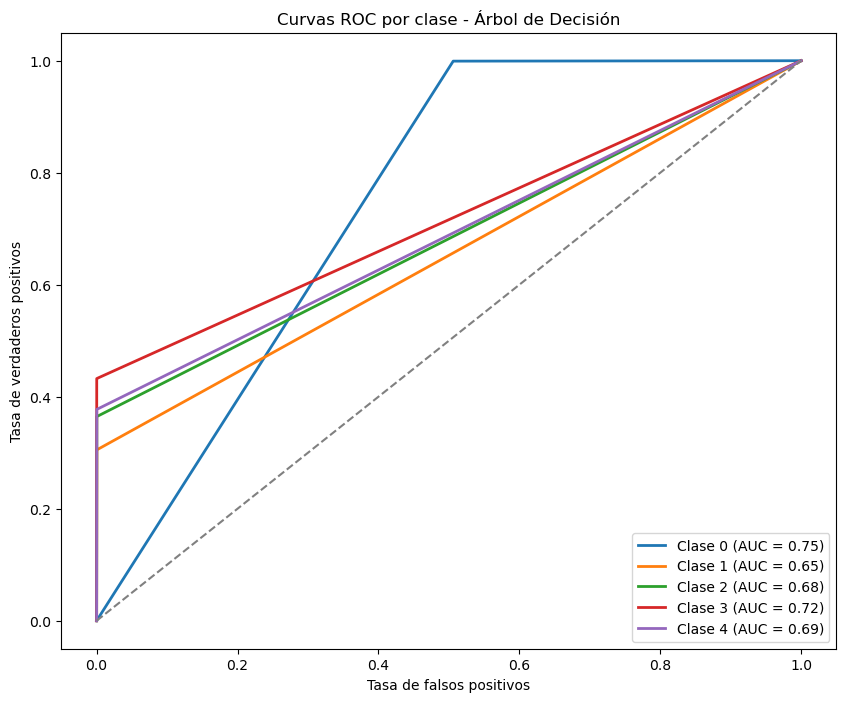

In [34]:
# Se genera una curva ROC que permita comparar todas las clases de un modelo

comparar_curvas_roc_multiclase(
    y_test_failure,
    y_prob_test_dt,
    "Árbol de Decisión"
)

Cargando modelo Random Forest para Failure Prediction
Resultados Random Forest (Failure Prediction):
 {'Accuracy': 0.9992107518152709, 'Precision': 0.999105210274656, 'Recall': 0.9992107518152709, 'F1-Score': 0.9990330799477875, 'ROC-AUC': 0.9878622009382989}


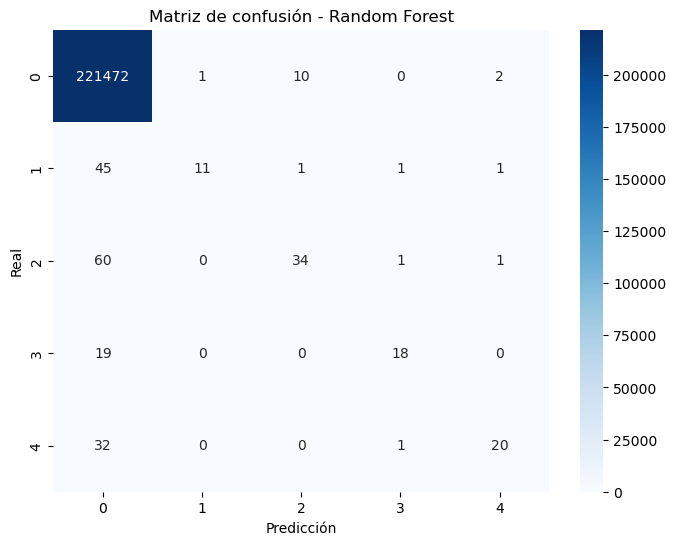

In [35]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/failure_rf_model.pkl"):
    print("Cargando modelo Random Forest para Failure Prediction")
    rf_model = joblib.load("models/failure_rf_model.pkl")
else:
    print("Entrenando modelo Random Forest para Failure Prediction")
    with open('hyperparams/failure_rf_best_params.json', 'r') as f:
        rf_params = json.load(f)
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train, y_train_failure)
    joblib.dump(rf_model, "models/failure_rf_model.pkl")

# Predicciones
y_pred_test_rf = rf_model.predict(X_test)
y_prob_test_rf = rf_model.predict_proba(X_test)  

# Métricas
resultados_rf = calcular_metricas_clasificacion(y_test_failure, y_pred_test_rf, y_prob_test_rf)
print("Resultados Random Forest (Failure Prediction):\n", resultados_rf)

# Matriz de confusión
mostrar_matriz_confusion(y_test_failure, y_pred_test_rf, "Random Forest")


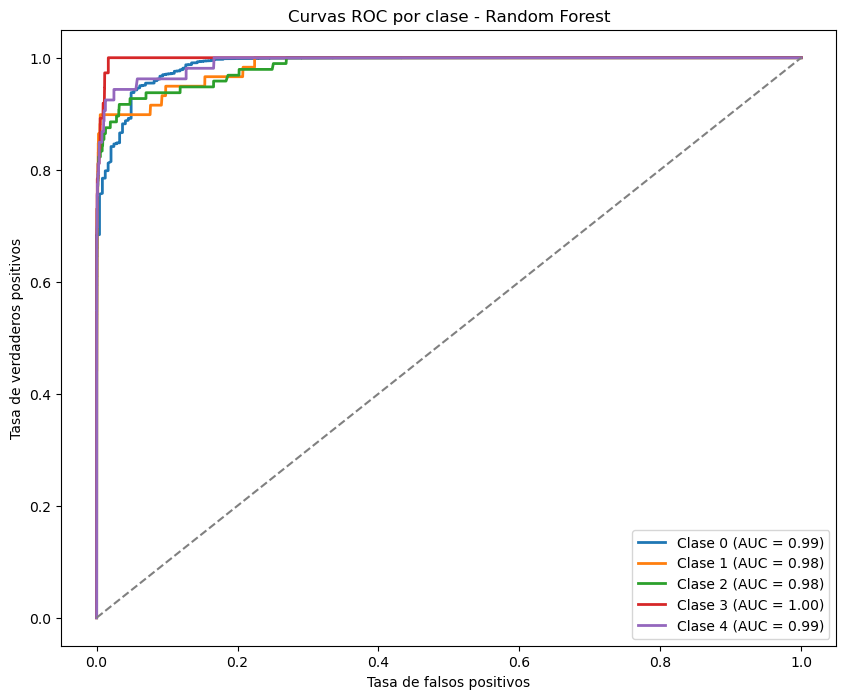

In [36]:
# Se genera una curva ROC que permita comparar todas las clases de un modelo

comparar_curvas_roc_multiclase(
    y_test_failure,
    y_prob_test_rf,
    "Random Forest"
)

Cargando modelo SVM para Failure Prediction
Resultados SVM (Failure Prediction):
 {'Accuracy': 0.9989717223650385, 'Precision': 0.9987000697428691, 'Recall': 0.9989717223650385, 'F1-Score': 0.9987756745660661, 'ROC-AUC': 0.940066729187827}


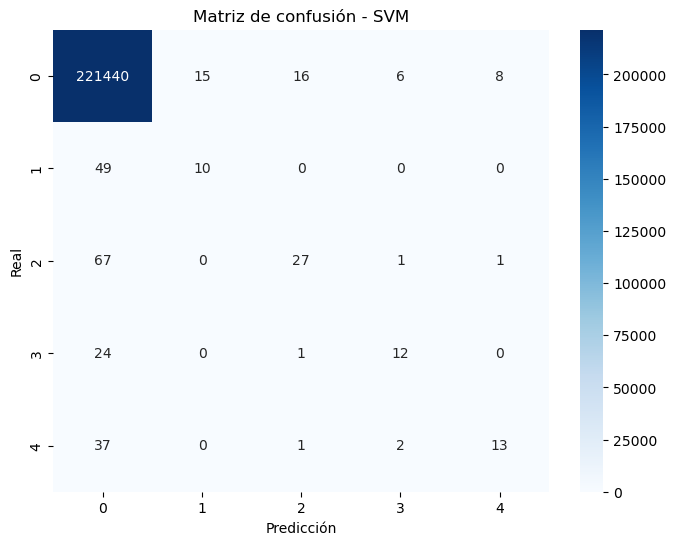

In [37]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/failure_svm_model.pkl"):
    print("Cargando modelo SVM para Failure Prediction")
    svm_model = joblib.load("models/failure_svm_model.pkl")
else:
    print("Entrenando modelo SVM para Failure Prediction")
    with open('hyperparams/failure_svm_best_params.json', 'r') as f:
        svm_params = json.load(f)
    svm_model = SVC(probability=True, **svm_params)  
    svm_model.fit(X_train, y_train_failure)
    joblib.dump(svm_model, "models/failure_svm_model.pkl")

# Predicciones
y_pred_test_svm = svm_model.predict(X_test)
y_prob_test_svm = svm_model.predict_proba(X_test)  

# Métricas
resultados_svm = calcular_metricas_clasificacion(y_test_failure, y_pred_test_svm, y_prob_test_svm)
print("Resultados SVM (Failure Prediction):\n", resultados_svm)

# Matriz de confusión
mostrar_matriz_confusion(y_test_failure, y_pred_test_svm, "SVM")


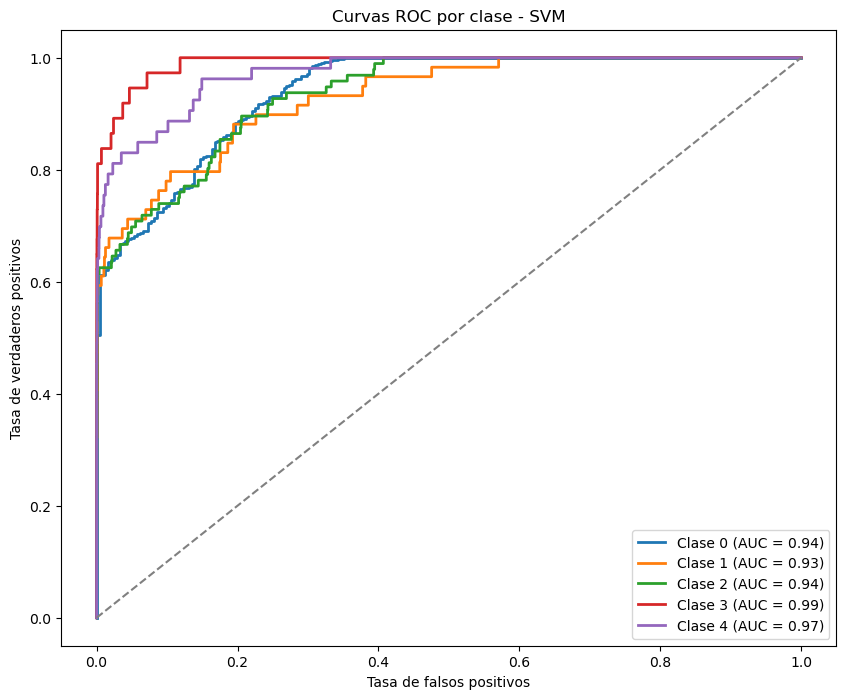

In [38]:
# Se genera una curva ROC que permita comparar todas las clases de un modelo

comparar_curvas_roc_multiclase(
    y_test_failure,
    y_prob_test_svm,
    "SVM"
)

Cargando modelo Redes Neuronales para Failure Prediction
6930/6930 ━━━━━━━━━━━━━━━━━━━━ 6s 848us/step
Resultados Redes Neuronales (Keras - Failure Prediction):
 {'Accuracy': 0.9991295720019844, 'Precision': 0.9990538345817654, 'Recall': 0.9991295720019844, 'F1-Score': 0.9990378469387524, 'ROC-AUC': 0.9856435361873993}


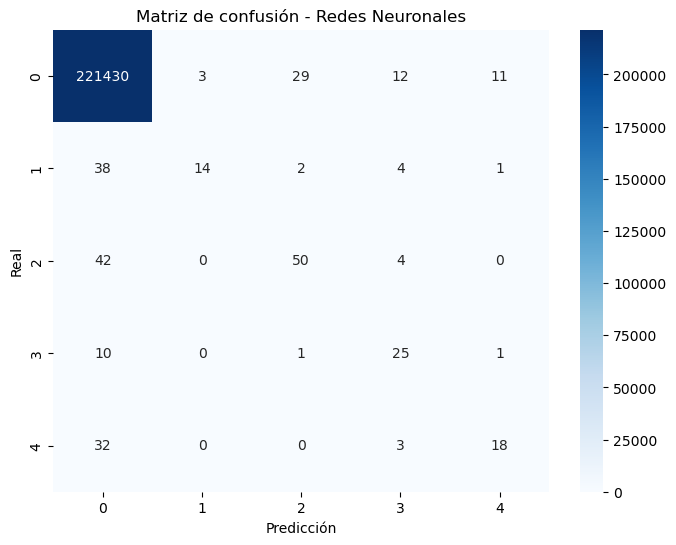

In [39]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/failure_nn_model.keras"):
    print("Cargando modelo Redes Neuronales para Failure Prediction")
    nn_model = load_model("models/failure_nn_model.keras")
else:
    print("Entrenando modelo Redes Neuronales para Failure Prediction")
    with open('hyperparams/failure_nn_best_params.json', 'r') as f:
        nn_params = json.load(f)
    
    # Se crea el modelo
    nn_model = Sequential()
    nn_model.add(Dense(nn_params['num_units'], activation='relu', input_dim=X_train.shape[1]))
    nn_model.add(Dropout(nn_params['dropout_rate']))
    nn_model.add(Dense(len(np.unique(y_train_failure)), activation='softmax'))  # Salida multiclase
    optimizer = Adam(learning_rate=nn_params['learning_rate'])
    nn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Se entrena el modelo
    nn_model.fit(
        X_train, y_train_failure,
        validation_data=(X_val, y_val_failure),
        batch_size=nn_params['batch_size'],
        epochs=nn_params['num_epochs'],
        verbose=1
    )
    nn_model.save("models/failure_nn_model.keras")

# Predicciones
y_prob_test_nn = nn_model.predict(X_test)  
y_pred_test_nn = np.argmax(y_prob_test_nn, axis=1)  

# Métricas
resultados_nn = calcular_metricas_clasificacion(y_test_failure, y_pred_test_nn, y_prob_test_nn)
print("Resultados Redes Neuronales (Keras - Failure Prediction):\n", resultados_nn)

# Matriz de confusión
mostrar_matriz_confusion(y_test_failure, y_pred_test_nn, "Redes Neuronales")


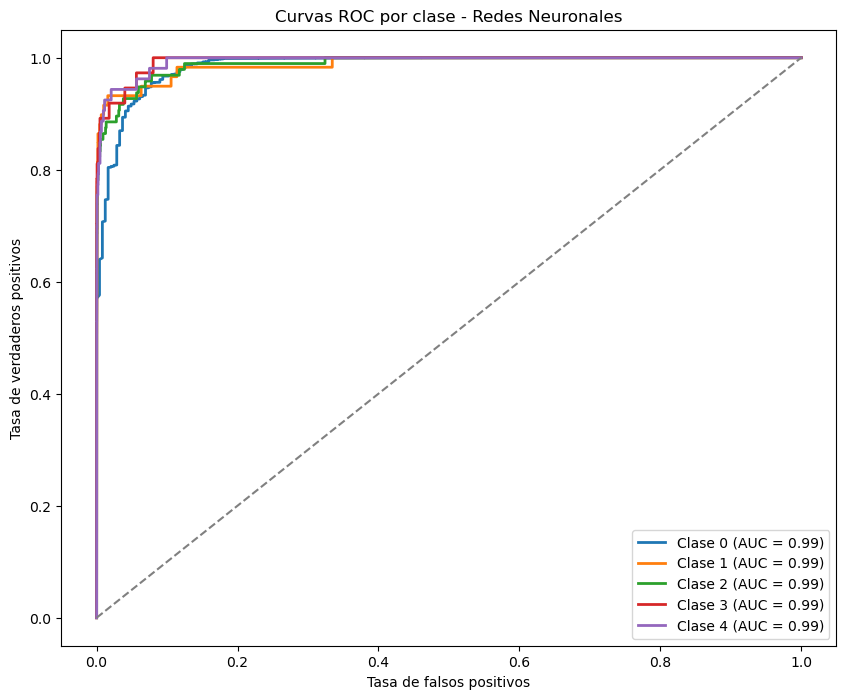

In [40]:
# Se genera una curva ROC que permita comparar todas las clases de un modelo

comparar_curvas_roc_multiclase(
    y_test_failure,
    y_prob_test_nn,
    "Redes Neuronales"
)

In [41]:
# Resultados
resultados_totales_failure = pd.DataFrame([
    {"Modelo": "Regresión Logística", **resultados_lr},
    {"Modelo": "Árboles de Decisión", **resultados_dt},
    {"Modelo": "Random Forest", **resultados_rf},
    {"Modelo": "SVM", **resultados_svm},
    {"Modelo": "Redes Neuronales (Keras)", **resultados_nn}
])

# Se muestran los resultados
print("Resultados para Failure Prediction:")
print(resultados_totales_failure)


Resultados para Failure Prediction:
                     Modelo  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0       Regresión Logística  0.999121   0.998978  0.999121  0.999021  0.980617
1       Árboles de Decisión  0.998548   0.998676  0.998548  0.998608  0.746499
2             Random Forest  0.999211   0.999105  0.999211  0.999033  0.987862
3                       SVM  0.998972   0.998700  0.998972  0.998776  0.940067
4  Redes Neuronales (Keras)  0.999130   0.999054  0.999130  0.999038  0.985644


## 4.4 Entrenar modelos para Near Failure (Clasificación binaria)

Cargando modelo de Regresión Logística para Near Failure Prediction
Resultados Regresión Logística (Near Failure):
 {'Accuracy': 0.8763225544581248, 'Precision': 0.8449620881941374, 'Recall': 0.8763225544581248, 'F1-Score': 0.8194942984566799, 'ROC-AUC': 0.6198941068076774}


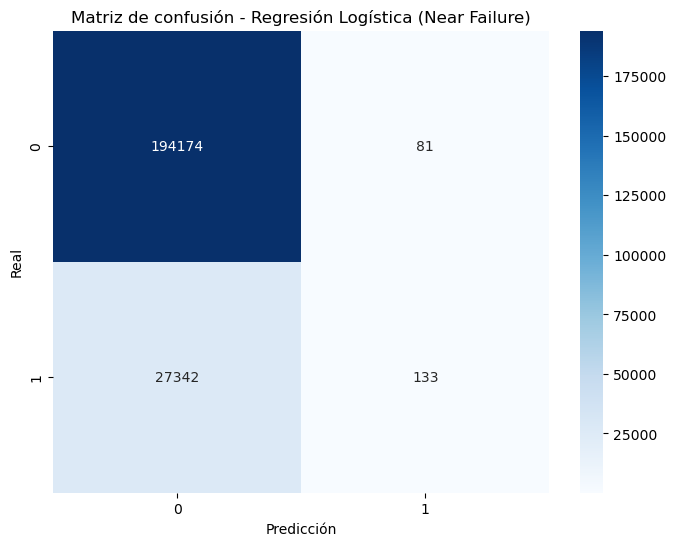

In [42]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/near_failure_lr_model.pkl"):
    print("Cargando modelo de Regresión Logística para Near Failure Prediction")
    lr_model = joblib.load("models/near_failure_lr_model.pkl")
else:
    print("Entrenando modelo de Regresión Logística para Near Failure Prediction")
    with open('hyperparams/near_failure_lr_best_params.json', 'r') as f:
        lr_params = json.load(f)
    lr_model = LogisticRegression(**lr_params)
    lr_model.fit(X_train, y_train_near_failure)
    joblib.dump(lr_model, "models/near_failure_lr_model.pkl")

# Predicciones
y_pred_test_lr = lr_model.predict(X_test)
y_prob_test_lr = lr_model.predict_proba(X_test)[:, 1]  

# Métricas
resultados_lr = calcular_metricas_clasificacion(y_test_near_failure, y_pred_test_lr, y_prob_test_lr)
print("Resultados Regresión Logística (Near Failure):\n", resultados_lr)

# Matriz de confusión
mostrar_matriz_confusion(y_test_near_failure, y_pred_test_lr, "Regresión Logística (Near Failure)")


Cargando modelo de Árbol de Decisión para Near Failure Prediction
Resultados Árbol de Decisión (Near Failure):
 {'Accuracy': 0.77201100437469, 'Precision': 0.7929553209408677, 'Recall': 0.77201100437469, 'F1-Score': 0.7820261917294569, 'ROC-AUC': 0.525145039672228}


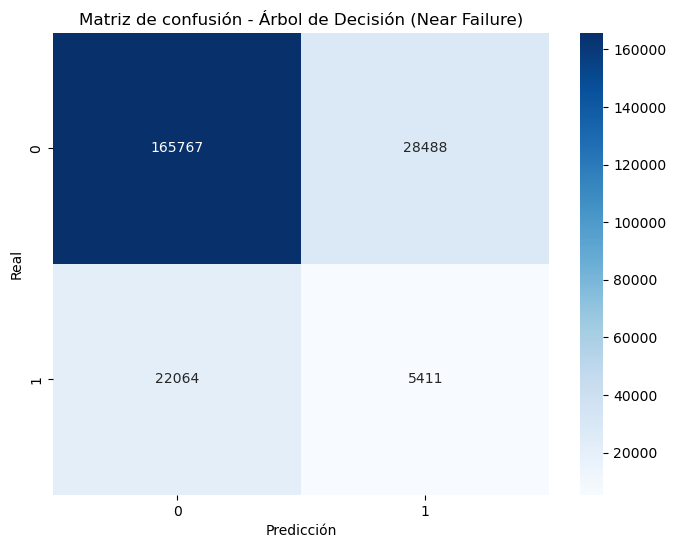

In [43]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/near_failure_dt_model.pkl"):
    print("Cargando modelo de Árbol de Decisión para Near Failure Prediction")
    dt_model = joblib.load("models/near_failure_dt_model.pkl")
else:
    print("Entrenando modelo de Árbol de Decisión para Near Failure Prediction")
    with open('hyperparams/near_failure_dt_best_params.json', 'r') as f:
        dt_params = json.load(f)
    dt_model = DecisionTreeClassifier(**dt_params)
    dt_model.fit(X_train, y_train_near_failure)
    joblib.dump(dt_model, "models/near_failure_dt_model.pkl")

# Predicciones
y_pred_test_dt = dt_model.predict(X_test)
y_prob_test_dt = dt_model.predict_proba(X_test)[:, 1]  

# Métricas
resultados_dt = calcular_metricas_clasificacion(y_test_near_failure, y_pred_test_dt, y_prob_test_dt)
print("Resultados Árbol de Decisión (Near Failure):\n", resultados_dt)

# Matriz de confusión
mostrar_matriz_confusion(y_test_near_failure, y_pred_test_dt, "Árbol de Decisión (Near Failure)")


Cargando modelo Random Forest para Near Failure Prediction
Resultados Random Forest (Near Failure):
 {'Accuracy': 0.8686781220403194, 'Precision': 0.811256207231116, 'Recall': 0.8686781220403194, 'F1-Score': 0.8256256622661022, 'ROC-AUC': 0.5844305782791768}


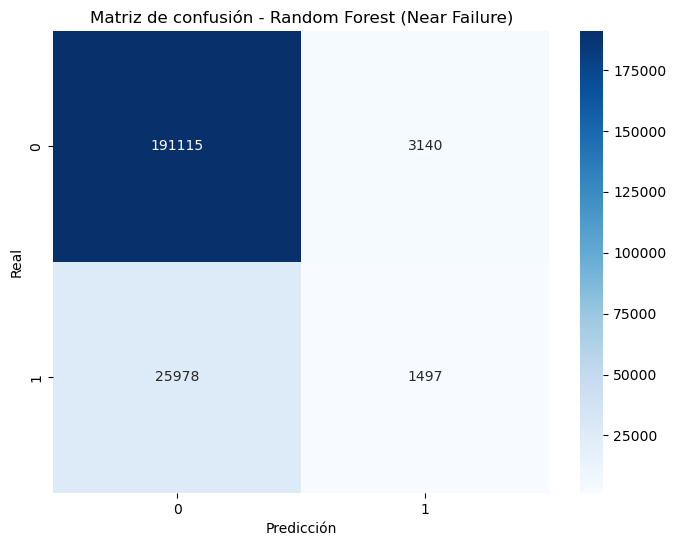

In [44]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/near_failure_rf_model.pkl"):
    print("Cargando modelo Random Forest para Near Failure Prediction")
    rf_model = joblib.load("models/near_failure_rf_model.pkl")
else:
    print("Entrenando modelo Random Forest para Near Failure Prediction")
    with open('hyperparams/near_failure_rf_best_params.json', 'r') as f:
        rf_params = json.load(f)
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train, y_train_near_failure)
    joblib.dump(rf_model, "models/near_failure_rf_model.pkl")

# Predicciones
y_pred_test_rf = rf_model.predict(X_test)
y_prob_test_rf = rf_model.predict_proba(X_test)[:, 1]

# Métricas
resultados_rf = calcular_metricas_clasificacion(y_test_near_failure, y_pred_test_rf, y_prob_test_rf)

print("Resultados Random Forest (Near Failure):\n", resultados_rf)


# Matriz de confusión
mostrar_matriz_confusion(y_test_near_failure, y_pred_test_rf, "Random Forest (Near Failure)")


In [45]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/near_failure_svm_model.pkl"):
    print("Cargando modelo SVM para Near Failure Prediction")
    svm_model = joblib.load("models/near_failure_svm_model.pkl")
else:
    print("Entrenando modelo SVM para Near Failure Prediction")
    with open('hyperparams/near_failure_svm_best_params.json', 'r') as f:
        svm_params = json.load(f)
    svm_model = SVC(probability=True, **svm_params, verbose=True) 
    svm_model.fit(X_train, y_train_near_failure)
    joblib.dump(svm_model, "models/near_failure_svm_model.pkl")

# Predicciones
y_pred_test_svm = svm_model.predict(X_test)
y_prob_test_svm = svm_model.predict_proba(X_test)[:, 1]  

# Métricas
resultados_svm = calcular_metricas_clasificacion(y_test_near_failure, y_pred_test_svm, y_prob_test_svm)
print("Resultados SVM (Near Failure):\n", resultados_svm)

# Matriz de confusión
mostrar_matriz_confusion(y_test_near_failure, y_pred_test_svm, "SVM (Near Failure)")


Cargando modelo Redes Neuronales para Near Failure Prediction
6930/6930 ━━━━━━━━━━━━━━━━━━━━ 6s 828us/step
Resultados Redes Neuronales (Keras - Near Failure):
 {'Accuracy': 0.876566093897984, 'Precision': 0.8361458593524099, 'Recall': 0.876566093897984, 'F1-Score': 0.8256964221835501, 'ROC-AUC': 0.6223927696137987}


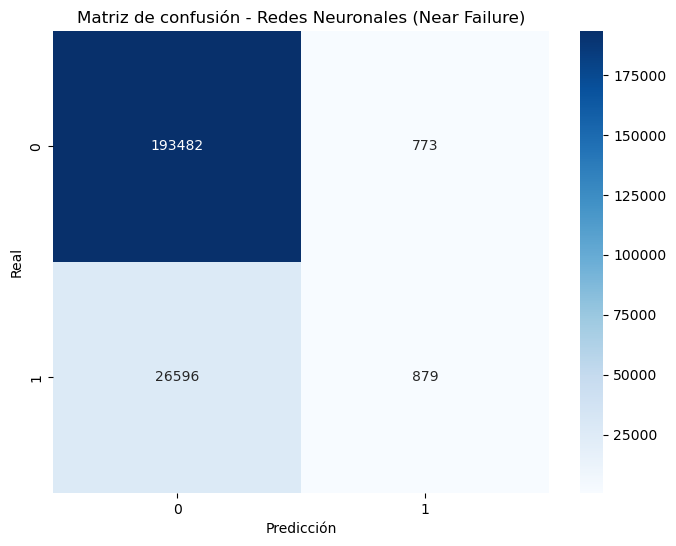

In [46]:
# Se carga el modelo guardado o se entrena uno nuevo y se guarda
if os.path.exists("models/near_failure_nn_model.keras"):
    print("Cargando modelo Redes Neuronales para Near Failure Prediction")
    nn_model = load_model("models/near_failure_nn_model.keras")
else:
    print("Entrenando modelo Redes Neuronales para Near Failure Prediction")
    with open('hyperparams/near_failure_nn_best_params.json', 'r') as f:
        nn_params = json.load(f)
    
    # Se crea el modelo
    nn_model = Sequential()
    nn_model.add(Dense(nn_params['num_units'], activation='relu', input_dim=X_train.shape[1]))
    nn_model.add(Dropout(nn_params['dropout_rate']))
    nn_model.add(Dense(1, activation='sigmoid'))  
    optimizer = Adam(learning_rate=nn_params['learning_rate'])
    nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Se entrena el modelo
    nn_model.fit(
        X_train, y_train_near_failure,
        validation_data=(X_val, y_val_near_failure),
        batch_size=nn_params['batch_size'],
        epochs=nn_params['num_epochs'],
        verbose=1
    )
    nn_model.save("models/near_failure_nn_model.keras")

# Predicciones
y_prob_test_nn = nn_model.predict(X_test).flatten() 
y_pred_test_nn = (y_prob_test_nn > 0.5).astype(int) 

# Métricas
resultados_nn = calcular_metricas_clasificacion(y_test_near_failure, y_pred_test_nn, y_prob_test_nn)
print("Resultados Redes Neuronales (Keras - Near Failure):\n", resultados_nn)

# Matriz de confusión
mostrar_matriz_confusion(y_test_near_failure, y_pred_test_nn, "Redes Neuronales (Near Failure)")


In [47]:
# Resultados
resultados_totales_near_failure = pd.DataFrame([
    {"Modelo": "Regresión Logística", **resultados_lr},
    {"Modelo": "Árboles de Decisión", **resultados_dt},
    {"Modelo": "Random Forest", **resultados_rf},
    #{"Modelo": "SVM", **resultados_svm},
    {"Modelo": "Redes Neuronales (Keras)", **resultados_nn}
])

# Se muestran los resultados
print("Resultados para Near Failure Prediction:")
print(resultados_totales_near_failure)


Resultados para Near Failure Prediction:
                     Modelo  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0       Regresión Logística  0.876323   0.844962  0.876323  0.819494  0.619894
1       Árboles de Decisión  0.772011   0.792955  0.772011  0.782026  0.525145
2             Random Forest  0.868678   0.811256  0.868678  0.825626  0.584431
3  Redes Neuronales (Keras)  0.876566   0.836146  0.876566  0.825696  0.622393


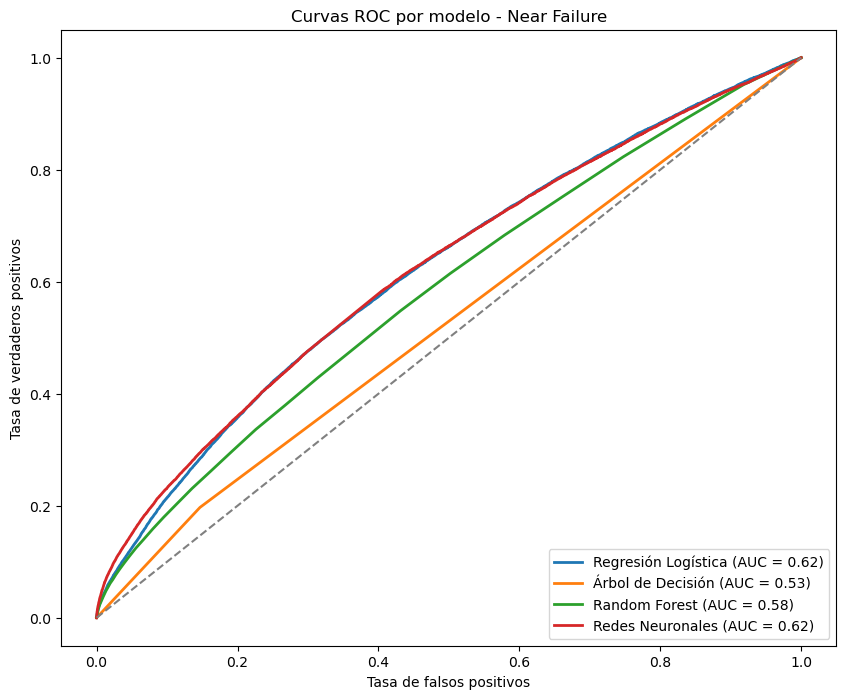

In [48]:
# Se genera una curva ROC que permita comparar todos los modelos

# Se crea un diccionario con las probabilidades de todos los modelos
modelos_dict = {
    'Regresión Logística': y_prob_test_lr,
    'Árbol de Decisión': y_prob_test_dt,
    'Random Forest': y_prob_test_rf,
#     'SVM': y_prob_test_SVM,
    'Redes Neuronales': y_prob_test_nn
}

# Se genera la gráfica comparativa
comparar_curvas_roc_binario(y_test_near_failure, modelos_dict)
